# Spotify Music Recommendation System

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")


In [2]:
data_path = 'data/data.csv'
data = pd.read_csv(data_path)
data.head(3)


,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.121,0.03110,0.00697,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.114,0.02490,0.02500,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.210,0.00238,0.00000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative


In [3]:
data.dtypes

artist_name          object
id                   object
track_name           object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
artist_pop            int64
genres               object
track_pop             int64
genres_list          object
subjectivity         object
polarity             object
dtype: object

### Using the Spotify API

In [4]:
client_id = '4379e8dc929f4f3d8b296962fb549d56'
client_secret= '08a15f73be3742f18227aec6fb9e61b4'
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
        
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='https://mysongrecommender/dashboard/')
sp = spotipy.Spotify(auth=token)

In [5]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
id_name

{'Temp': '0aLsEgykdP5Boh3fWmazRW',
 'Feel good songs': '20R375waLb0fRUriQYL1iO',
 'Jogging track': '4c9aOsOYUpjS97XfEmm1l6',
 'Wilson’s Heart': '3BMq2SGR78Ptn4Yz7Jo3mK',
 'Infinity': '2ZwiIjZseXPSXpo2w1VpQZ',
 'The Winds of Winter': '29c9hEgN75p70uCN6cBwZ3',
 'Nevermind': '0LN1MMEHaowE5Dk9LtOFL7',
 'Days gone bye': '4EdpwLLnhlg4qhZJiHxZ7F'}

### Exploratory Data Analysis

In [6]:
len(data)

34247

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'loudness'),
 Text(3.5, 0, 'speechiness'),
 Text(4.5, 0, 'acousticness'),
 Text(5.5, 0, 'instrumentalness'),
 Text(6.5, 0, 'liveness'),
 Text(7.5, 0, 'valence'),
 Text(8.5, 0, 'tempo'),
 Text(9.5, 0, 'artist_pop'),
 Text(10.5, 0, 'track_pop')]

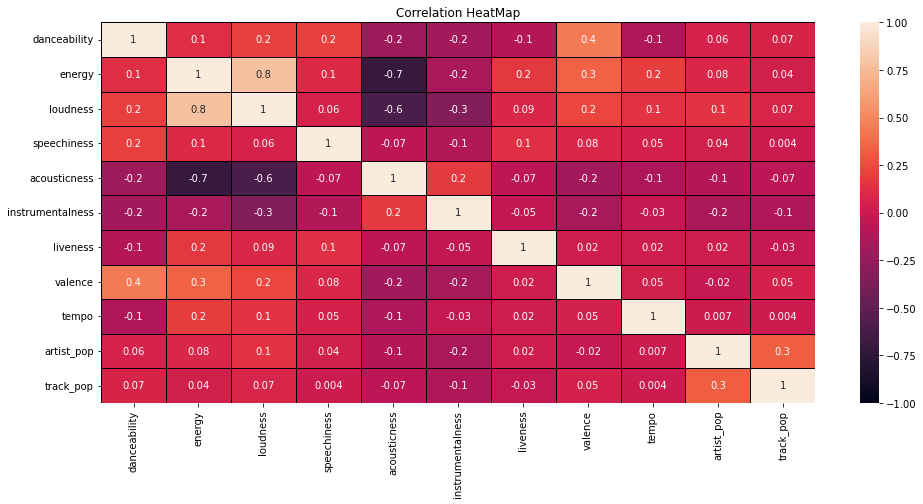

In [7]:
corr_df=data.drop(["key","mode"],axis=1).corr(method="pearson")
plt.figure(figsize=(16,7))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g", vmin=-1, vmax=1, center=0, cmap="rocket", linewidths=1, linecolor="Black")
heatmap.set_title("Correlation HeatMap")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

[Text(0.5, 1.0, 'Artist Popularity vs Energy Correlation')]

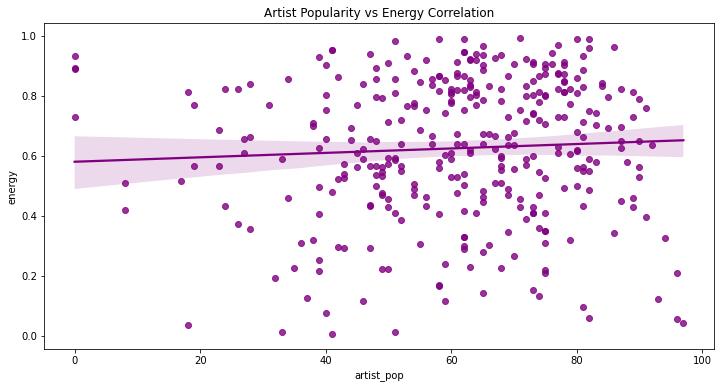

In [8]:
sample_data=data.sample(int(0.01*len(data)))
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="energy", x="artist_pop",color="purple").set(title="Artist Popularity vs Energy Correlation")

[Text(0.5, 1.0, 'Artist popularity vs  Track popularity')]

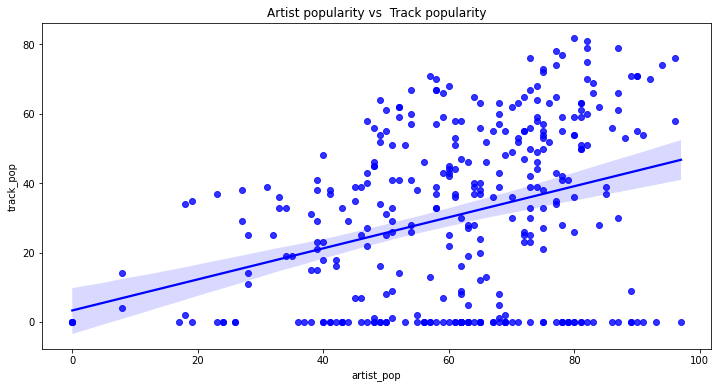

In [9]:
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="track_pop", x="artist_pop",color="blue").set(title="Artist popularity vs  Track popularity")

In [10]:
data[['artist_name','track_name']]


,artist_name,track_name
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop)
1,Britney Spears,Toxic
2,Beyoncé,Crazy In Love
3,Justin Timberlake,Rock Your Body
4,Shaggy,It Wasn't Me
...,...,...
34242,Jon D,I Don't Know
34243,Big Words,The Answer
34244,Allan Rayman,25.22
34245,Jon Jason,Good Feeling


In [11]:
def remove_duplicates(df):
    
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['track_name'],axis = 1)
    return df.drop_duplicates('artists_song')

unique_songs = remove_duplicates(data)
print("Are all songs unique: ",len(pd.unique(unique_songs.artists_song))==len(unique_songs))

Are all songs unique:  True


In [12]:
def column(df):
       
       return df[['artist_name','id','track_name','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "artist_pop", "genres", "track_pop"]]
unique_songs = column(unique_songs)
unique_songs.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2


In [13]:
def genreprocessing(df):
    
    df['genres_list'] = df['genres'].apply(lambda x: x.split(" "))
    return df
unique_songs = genreprocessing(unique_songs)
unique_songs['genres_list'].head()

0    [dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...
1                      [dance_pop, pop, post-teen_pop]
2                                [dance_pop, pop, r&b]
3                                     [dance_pop, pop]
4                             [pop_rap, reggae_fusion]
Name: genres_list, dtype: object

In [14]:
def playlistprocessing(df):
    
    df = remove_duplicates(df)
    df = column(df)
    df = genreprocessing(df)

    return df

In [15]:
!pip install textblob
from textblob import TextBlob

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    
    return TextBlob(text).sentiment.polarity

def polarityAnalysis(score, task="polarity"):
    
    if task == "subjectivity":
        if score < 1/3:
            return "low"
        elif score > 1/3:
            return "high"
        else:
            return "medium"
    else:
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

def sentimentAnalysis(df, text_col):
    
    df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: polarityAnalysis(x,"subjectivity"))
    df['polarity'] = df[text_col].apply(getPolarity).apply(polarityAnalysis)
    return df

In [16]:
sentiment = sentimentAnalysis(unique_songs, "track_name")
sentiment.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"[dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"[dance_pop, pop, post-teen_pop]",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"[dance_pop, pop, r&b]",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"[dance_pop, pop]",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"[pop_rap, reggae_fusion]",low,Neutral


In [17]:
def ohe_prep(df, column, new_name): 

    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [18]:
subject_ohe = ohe_prep(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

In [19]:
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(unique_songs['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|21st_century_classical    0.0
genre|432hz                     0.0
genre|_hip_hop                  0.0
genre|_roll                     0.0
genre|a_cappella                0.0
                               ... 
genre|zambian_hip_hop           0.0
genre|zhongguo_feng             0.0
genre|zolo                      0.0
genre|zouk                      0.0
genre|zouk_riddim               0.0
Name: 0, Length: 2147, dtype: float64

In [20]:
print(unique_songs['artist_pop'].describe())

count    34247.000000
mean        61.916606
std         19.120147
min          0.000000
25%         51.000000
50%         65.000000
75%         76.000000
max        100.000000
Name: artist_pop, dtype: float64


In [21]:
pop = unique_songs[["artist_pop"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns)
pop_scaled.head()

,artist_pop
0,0.74
1,0.84
2,0.86
3,0.82
4,0.75


In [22]:
def create_feature_set(df, float_cols):
    
    # Genre listing
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['genres_list'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.drop(columns='genre|unknown') 
    genre_df.reset_index(drop = True, inplace=True)
    
    # Sentiment analysis
    df = sentimentAnalysis(df, "track_name")

    # One-hot Encoding
    subject_ohe = ohe_prep(df, 'subjectivity','subject') * 0.3
    polar_ohe = ohe_prep(df, 'polarity','polar') * 0.5
    key_ohe = ohe_prep(df, 'key','key') * 0.5
    mode_ohe = ohe_prep(df, 'mode','mode') * 0.5

    # Normalization
    # Scale popularity columns
    pop = df[["artist_pop","track_pop"]].reset_index(drop = True)
    scaler = MinMaxScaler()
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

    # Scale audio columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # Concanenate all features
    final = pd.concat([genre_df, floats_scaled, pop_scaled, subject_ohe, polar_ohe, key_ohe, mode_ohe], axis = 1)
    
    # Add song id
    final['id']=df['id'].values
    
    return final

In [23]:
float_cols = unique_songs.dtypes[unique_songs.dtypes == 'float64'].index.values
unique_songs.to_csv("data/data.csv", index = False)

# Generate features
complete_feature_set = create_feature_set(unique_songs, float_cols=float_cols)
complete_feature_set.to_csv("data/complete_feature.csv", index = False)
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|_roll,genre|a_cappella,genre|abstract_beats,genre|abstract_hip_hop,genre|accordion,genre|acid_jazz,genre|acid_rock,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0UaMYEvWZi0ZqiDOoHU3YI
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,6I9VzXrHxO9rA9A5euc8Ak
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0WqIKmW4BTrj3eJFmnCKMv
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1AWQoqb9bSvzTjaLralEkT
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1lzr43nnXAijIGYnCT8M8H


In [24]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'track_name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [60]:
MyPlaylist = create_necessary_outputs('Infinity', id_name,unique_songs)

In [61]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['track_name'].values[i], fontsize = 10)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

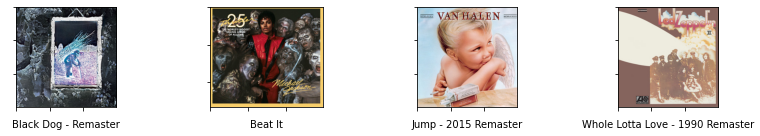

In [62]:
visualize_songs(MyPlaylist)

In [63]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist


In [64]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [65]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, MyPlaylist, 1.09)
complete_feature_set_playlist_vector_EDM.shape

(2178,)

In [66]:
reco_top40 = generate_playlist_recos(unique_songs, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)
reco_top40

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity,sim,url
7578,Aerosmith,74uGhWp4BYpjFj1V2DzgoO,Pink,0.432,0.751,0,-5.124,1,0.0423,0.013400,...,0.776,171.850,78,album_rock classic_rock hard_rock rock,65,"[album_rock, classic_rock, hard_rock, rock]",low,Negative,0.833817,https://i.scdn.co/image/ab67616d00001e0268f886...
6012,Aerosmith,6gQUbFwwdYXlKdmqRoWKJe,Dude (Looks Like A Lady),0.540,0.982,4,-2.962,0,0.0458,0.435000,...,0.910,126.294,78,album_rock classic_rock hard_rock rock,73,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.795533,https://i.scdn.co/image/ab67616d00001e02a8a965...
15097,Led Zeppelin,4PRGxHpCpF2yoOHYKQIEwD,Rock And Roll,0.317,0.887,9,-7.292,1,0.0375,0.000582,...,0.871,169.613,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.792338,https://i.scdn.co/image/ab67616d00001e02c8a11e...
6021,Aerosmith,2KCJYwlBWxdlwyIYckIf6V,Rag Doll,0.579,0.954,4,-3.947,1,0.0558,0.583000,...,0.583,93.448,78,album_rock classic_rock hard_rock rock,63,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.790735,https://i.scdn.co/image/ab67616d00001e02a8a965...
26598,Aerosmith,74irxdVWstNlEQjsvArITq,Crazy,0.370,0.866,6,-3.879,0,0.0384,0.086800,...,0.427,162.086,78,album_rock classic_rock hard_rock rock,76,"[album_rock, classic_rock, hard_rock, rock]",high,Negative,0.789662,https://i.scdn.co/image/ab67616d00001e02587b26...
12667,Led Zeppelin,0QwZfbw26QeUoIy82Z2jYp,Good Times Bad Times,0.476,0.717,9,-9.192,1,0.0949,0.038200,...,0.753,93.584,80,album_rock classic_rock hard_rock rock,69,"[album_rock, classic_rock, hard_rock, rock]",high,Positive,0.789263,https://i.scdn.co/image/ab67616d00001e026f2f49...
15086,Led Zeppelin,3MODES4TNtygekLl146Dxd,Ramble On,0.468,0.607,9,-11.367,1,0.0336,0.072000,...,0.886,98.429,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.789249,https://i.scdn.co/image/ab67616d00001e02fc4f17...
26434,Led Zeppelin,4CWaV1xRCEJQj0QJJif60x,Living Loving Maid [She's Just A Woman],0.476,0.828,9,-8.060,1,0.0357,0.000124,...,0.916,152.160,80,album_rock classic_rock hard_rock rock,44,"[album_rock, classic_rock, hard_rock, rock]",high,Positive,0.789220,https://i.scdn.co/image/ab67616d00001e02fc4f17...
6022,Aerosmith,2ATTIE0sKIXysApJPlR3sB,Same Old Song and Dance,0.565,0.628,9,-10.368,1,0.0330,0.067200,...,0.706,133.194,78,album_rock classic_rock hard_rock rock,56,"[album_rock, classic_rock, hard_rock, rock]",low,Positive,0.788008,https://i.scdn.co/image/ab67616d00001e02e21078...
32203,Led Zeppelin,0RR8wuHHc5NqSFxhPDDBNV,Communication Breakdown - 22/6/69 Pop Sundae,0.367,0.779,9,-8.334,1,0.0488,0.005740,...,0.794,90.354,80,album_rock classic_rock hard_rock rock,51,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.787475,https://i.scdn.co/image/ab67616d00001e02ce69f6...


In [67]:
reco_top40.head(10)

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity,sim,url
7578,Aerosmith,74uGhWp4BYpjFj1V2DzgoO,Pink,0.432,0.751,0,-5.124,1,0.0423,0.013400,...,0.776,171.850,78,album_rock classic_rock hard_rock rock,65,"[album_rock, classic_rock, hard_rock, rock]",low,Negative,0.833817,https://i.scdn.co/image/ab67616d00001e0268f886...
6012,Aerosmith,6gQUbFwwdYXlKdmqRoWKJe,Dude (Looks Like A Lady),0.540,0.982,4,-2.962,0,0.0458,0.435000,...,0.910,126.294,78,album_rock classic_rock hard_rock rock,73,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.795533,https://i.scdn.co/image/ab67616d00001e02a8a965...
15097,Led Zeppelin,4PRGxHpCpF2yoOHYKQIEwD,Rock And Roll,0.317,0.887,9,-7.292,1,0.0375,0.000582,...,0.871,169.613,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.792338,https://i.scdn.co/image/ab67616d00001e02c8a11e...
6021,Aerosmith,2KCJYwlBWxdlwyIYckIf6V,Rag Doll,0.579,0.954,4,-3.947,1,0.0558,0.583000,...,0.583,93.448,78,album_rock classic_rock hard_rock rock,63,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.790735,https://i.scdn.co/image/ab67616d00001e02a8a965...
26598,Aerosmith,74irxdVWstNlEQjsvArITq,Crazy,0.370,0.866,6,-3.879,0,0.0384,0.086800,...,0.427,162.086,78,album_rock classic_rock hard_rock rock,76,"[album_rock, classic_rock, hard_rock, rock]",high,Negative,0.789662,https://i.scdn.co/image/ab67616d00001e02587b26...
12667,Led Zeppelin,0QwZfbw26QeUoIy82Z2jYp,Good Times Bad Times,0.476,0.717,9,-9.192,1,0.0949,0.038200,...,0.753,93.584,80,album_rock classic_rock hard_rock rock,69,"[album_rock, classic_rock, hard_rock, rock]",high,Positive,0.789263,https://i.scdn.co/image/ab67616d00001e026f2f49...
15086,Led Zeppelin,3MODES4TNtygekLl146Dxd,Ramble On,0.468,0.607,9,-11.367,1,0.0336,0.072000,...,0.886,98.429,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.789249,https://i.scdn.co/image/ab67616d00001e02fc4f17...
26434,Led Zeppelin,4CWaV1xRCEJQj0QJJif60x,Living Loving Maid [She's Just A Woman],0.476,0.828,9,-8.060,1,0.0357,0.000124,...,0.916,152.160,80,album_rock classic_rock hard_rock rock,44,"[album_rock, classic_rock, hard_rock, rock]",high,Positive,0.789220,https://i.scdn.co/image/ab67616d00001e02fc4f17...
6022,Aerosmith,2ATTIE0sKIXysApJPlR3sB,Same Old Song and Dance,0.565,0.628,9,-10.368,1,0.0330,0.067200,...,0.706,133.194,78,album_rock classic_rock hard_rock rock,56,"[album_rock, classic_rock, hard_rock, rock]",low,Positive,0.788008,https://i.scdn.co/image/ab67616d00001e02e21078...
32203,Led Zeppelin,0RR8wuHHc5NqSFxhPDDBNV,Communication Breakdown - 22/6/69 Pop Sundae,0.367,0.779,9,-8.334,1,0.0488,0.005740,...,0.794,90.354,80,album_rock classic_rock hard_rock rock,51,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.787475,https://i.scdn.co/image/ab67616d00001e02ce69f6...


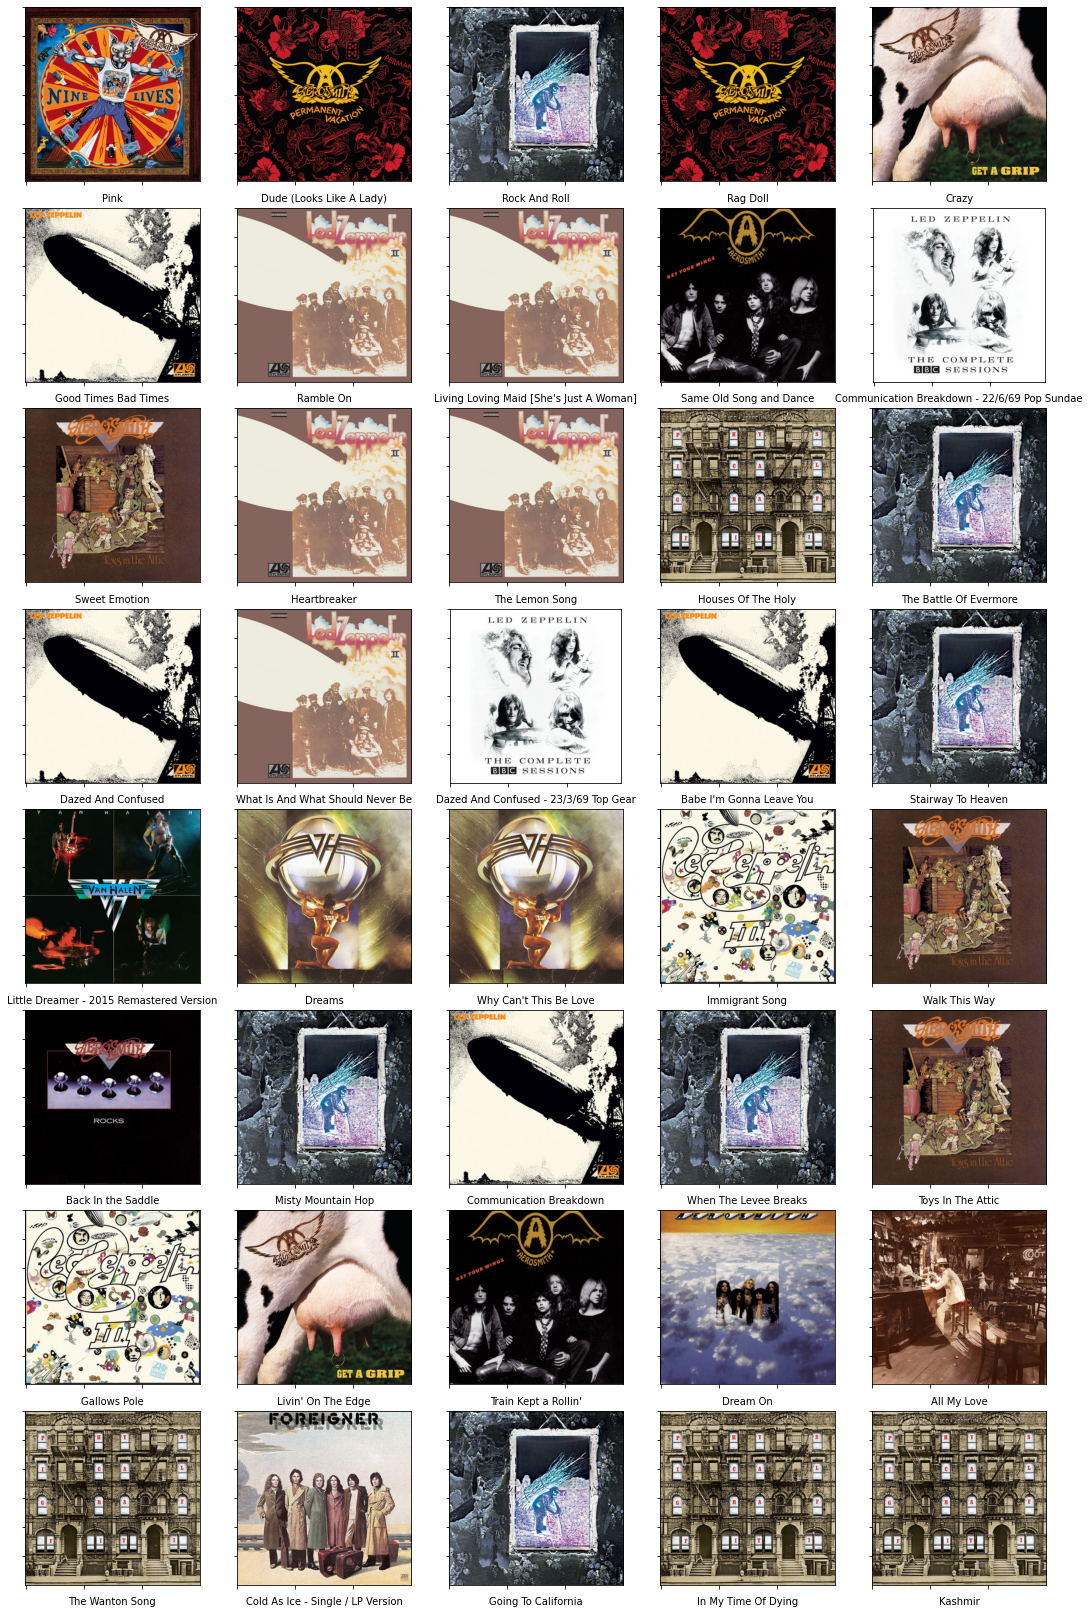

In [68]:
visualize_songs(reco_top40)

------End of Project-----